# Batch Processing!
#### A notebook to show some of the capilities available through the pCunch package

This is certainly not an exhaustive look at everything that the pCrunch module can do, but should hopefully provide some insight. 
...or, maybe I'm just procrastinating doing more useful work.

In [1]:
# Python Modules and instantiation
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import os
# %matplotlib widget
# ROSCO toolbox modules 
from ROSCO_toolbox import utilities as rosco_utilities
# WISDEM modules
from wisdem.aeroelasticse.Util import FileTools
# Batch Analysis tools
from pCrunch import Processing, Analysis
from pCrunch import pdTools

# Instantiate fast_IO
fast_io = rosco_utilities.FAST_IO()
fast_pl = rosco_utilities.FAST_Plots()

import importlib
Processing = importlib.reload(Processing)
Analysis = importlib.reload(Analysis)

## Define file paths and filenames
I'm loading a case matrix that is output when using wisdem.aeroelasticse.CaseGen_General to run a series of batch runs to initialize the output files here. 

Note that this isn't necessary, just my workflow in this notebook.

In [2]:
# point to some file paths
outfile_base = ['/Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/']
fname_case_matrix = [os.path.join(outfile_base[0],'case_matrix.yaml')]
case_names   = ['BAR01']

output_folder= '/Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/Plots_200812/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)


In [3]:
# Load case matrix into dataframe
cm = [''] * len(outfile_base)
for i in range(len(outfile_base)):
    case_matrix = FileTools.load_yaml(fname_case_matrix[i], package=1)
    cm[i] = pd.DataFrame(case_matrix)   


# pull wind speed values from InflowWind filenames
windspeeds, seed, IECtype, cmw = Processing.get_windspeeds(cm[0], return_df=True)
cmw.head()

,"(IEC, DLC)","(AeroDyn15, AFAeroMod)","(AeroDyn15, AIDrag)","(AeroDyn15, DBEMT_Mod)","(AeroDyn15, HubLoss)","(AeroDyn15, SkewMod)","(AeroDyn15, TIDrag)","(AeroDyn15, TanInd)","(AeroDyn15, TipLoss)","(AeroDyn15, TwrAero)",...,"(ServoDyn, PitManRat3)","(ServoDyn, TPitManS1)","(ServoDyn, TPitManS2)","(ServoDyn, TPitManS3)","(ServoDyn, TimGenOf)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,0,BAR01_000,3.0,1,NTM
1,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,1,BAR01_001,3.0,2,NTM
2,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,2,BAR01_002,3.0,3,NTM
3,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,3,BAR01_003,3.0,4,NTM
4,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,4,BAR01_004,3.0,5,NTM


#### Comparison cases
I'm comparing two different controllers here, so I'm going to define two lists of output filenames, each corresponding to the output files from each controller

In [4]:
# Pare down case matrix for desired runs and load the outfiles
outfiles       = [''] * len(outfile_base)
outfiles_DLC11 = [''] * len(outfile_base)
import copy
cm_DLC11 = copy.copy(cm)
for i in range(len(outfile_base)):
    outnames   = []
    outnames_DLC11   = []
    drop_lines = []
    for j in range(len(cm[i])):
        outnames.append(outfile_base[i] + cm[i]['Case_Name'][j] + '.outb')
        if cm[i][('IEC', 'DLC')][j] == 1.1:
            outnames_DLC11.append(outfile_base[i] + cm[i]['Case_Name'][j] + '.outb')
        else:
            drop_lines.append(j)
    outfiles[i]       = outnames
    outfiles_DLC11[i] = outnames_DLC11
    drop_lines
    if drop_lines != []: 
        cm_DLC11[i] = cm_DLC11[i].drop(cm_DLC11[i].index[np.array(drop_lines)])

### outfiles
In the end, we just need a list of OpenFAST output files. Here, we have a structure that looks something like `[[], []]`. This could be extended any amount like `[[],[],...,[], []]`, or just be one list of strings `[]`.

## Now we can do some processing!

First, let's load the FAST_Processing class and initialize some parameters.


In [5]:
fp = Processing.FAST_Processing()
fp.OpenFAST_outfile_list = outfiles
fp.dataset_names = ['DLC1.1', 'DLC1.3']
fp.to = 120
fp.parallel_analysis = True
fp.save_LoadRanking = False
fp.save_SummaryStats = False
fp.verbose=True

# # Can defined specific variables for load ranking if desired
# fp.ranking_vars = [["RotSpeed"], 
#                     ["OoPDefl1", "OoPDefl2", "OoPDefl3"], 
#                     ['RootMxc1', 'RootMxc2', 'RootMxc3'],
#                     ['TwrBsFyt'],
#                     ] 

#### The fast way to compare things.
We could now collect all of the summary stats and load rankings using:
```
stats,load_rankings = fp.batch_processing()
```
In `fp.batch_processing()` most of the analysis is done for any structure of data. I'm going to step through things a bit more piecewise in this notebook, however.

NOTE: The goal in `batch_processing` is to have a "do anything" script. It is a work in progress, but getting there...

In [6]:
# stats,load_rankings = fp.batch_processing()

## Design Comparisons
We can use fp.design_comparison to compare multiple sets of runs (like we are in this case...). This will generate summary stats and load rankings, running in parrallel when it can and is told to. `fp.batch_processing()` functionally does the same thing if we give it an outfile matrix with equal size lists. We'll show the design comparison here to show a break down

In [7]:
stats, load_ranking = fp.design_comparison(outfiles)
stats_DLC11, load_ranking_DLC11 = fp.design_comparison(outfiles_DLC11)

Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_049.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_021.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_035.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_028.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_007.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_042.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_000.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_014.outb
Processing data for BAR01_014
Processing data for BAR01_007
Processing data for BAR01_028
Processing data for BAR01_049
Processing data for BAR01_021
Processing data for BAR01_035
Proc

Processing data for BAR01_056
Processing data for BAR01_063
Processing data for BAR01_070
Processing data for BAR01_077
Processing data for BAR01_084
Processing data for BAR01_091
Processing data for BAR01_098
Processing data for BAR01_105
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_057.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_064.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_071.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_078.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_085.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_092.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_099.outb
Processing data for BAR01_057
Loading data fro

Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_155.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_162.outb
Processing data for BAR01_113
Processing data for BAR01_120
Processing data for BAR01_127
Processing data for BAR01_134
Processing data for BAR01_141
Processing data for BAR01_155
Processing data for BAR01_162
Processing data for BAR01_148
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_114.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_121.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_135.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_128.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_156.outb
Loading data from /Users/pbortolo/work/3_proje

Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_186.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_193.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_179.outb
Processing data for BAR01_172
Processing data for BAR01_193
Processing data for BAR01_186
Processing data for BAR01_179
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_173.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_180.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_187.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_194.outb
Processing data for BAR01_173
Processing data for BAR01_187
Processing data for BAR01_180
Processing data for BAR01_194
Loading data from /Users/pbortolo/work/3_proje

Processing data for BAR01_052
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_049.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_051.outb
Loading data from /Users/pbortolo/work/3_projects/3_BAR/loads/BAR01/loads_BAR01_200812/BAR01_053.outb
Processing data for BAR01_049
Processing data for BAR01_051
Processing data for BAR01_053
Calculating load rankings.


#### Breaking it down further...

`fp.batch_processing()` calls `Analysis.Loads_Analysls.full_loads_analysis()` to load openfast data, generate stats, and calculate load rankings. Because we defined `fp.parallel_analysis=True` this process was parallelized. This helps for speed and memory reasons, because now every openfast run is not saved. `fp.batch_processing()` then takes all of the output data and parses it back together. 

Separately, we call call `Analysis.Loads_Analysls.full_loads_analysis()` with `return_FastData=True` and all of the fast data will be returned. Because we are comparing data though, we'll stick with the design comparison tools.


### We can look at our data a bit further with pandas dataframes
The data here is just for a few runs for simplicity. Usually you'd do this for a LOT more cases...

In [8]:
stats_df = pdTools.dict2df(stats, names=case_names[0])
stats_df.head()

B                                                            \
         B1N1Fxl                                                             
             abs    integrated            max          mean            min   
0  174069.919150  5.552313e+07  174069.919150  13844.943663 -132040.527955   
1  159059.356904  3.173417e+07  159059.356904  15298.000204 -123027.854649   
2  173003.867409  8.362439e+06  173003.867409  19511.882580 -122982.297915   
3  167317.519578 -5.804763e+07  167317.519578  19074.025537 -129325.388491   
4  250622.531169  1.208932e+08  175547.142156   4382.689804 -250622.531169   

                                                                          ...  \
                       B1N1Fyl                                            ...   
            std            abs    integrated            max         mean  ...   
0  73039.523745  414560.341469 -1.052349e+07  414560.341469  2462.256910  ...   
1  74062.015926  412435.528699 -1.754404e+08  412435.528699  5473.427506  ...   
2  74379.217809  419939.946020 -7.362923e+07  419939.946020  7292.851125  ...   
3  76006.252882  423761.843555  2.411341e+08  423761.843555  3959.149399  ...   
4  88710.544223  413723.492503 -2.861731e+08  413723.492503  -448.693251  ...   

                                                                          \
  YawBrTDyt              YawPzn                                            
        min       std       abs integrated       max      mean       min   
0 -0.078122  0.023940  0.126921  -5.925633  0.126921 -0.006513 -0.125983   
1 -0.102213  0.031020  0.104263 -40.039192  0.097235 -0.002612 -0.104263   
2 -0.078642  0.019114  0.172442   3.691654  0.141382 -0.006088 -0.172442   
3 -0.107527  0.034880  0.149248   3.382448  0.119032 -0.001737 -0.149248   
4 -0.073001  0.023563  0.118031   4.607007  0.103031  0.006014 -0.118031   

                                                                           
                                                          meta             
        std                                           filename       name  
0  0.048560  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR01_000  
1  0.032246  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR01_001  
2  0.045176  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR01_002  
3  0.040531  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR01_003  
4  0.035111  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR01_004  

[5 rows x 3146 columns]

### Load Ranking
Lets re-run the load ranking for the sake of example. We'll have to load the analysis tools, and then run the load ranking for the stats we just found

In [9]:
fa = Analysis.Loads_Analysis()
fa.t0 = 120
fa.verbose = False

Define the ranking variables and statiscits of interest. Note that `len(ranking_vars) == len(ranking_stats)`! We can pass this a list of stats (multiple runs), a dictionary with one run of stats, or a pandas dataframe with the requisite stats. If the inner list contains multiple OpenFAST channels, the load_rankings function will find the min/max/mean of the collection of the channels (e.g., max out of plane tip deflection of all three blades).  

We'll also output a dictionary and a pandas DataFrame from `fa.load_ranking()`

In [10]:
fa.ranking_vars = [['TipDxb1', 'TipDxb2', 'TipDxb3'],    ['TipDxb1', 'TipDxb2', 'TipDxb3'],
                   ['B1TipTDxr','B2TipTDxr','B3TipTDxr'],['B1TipTDxr','B2TipTDxr','B3TipTDxr'],
                   ['B1TipRDzr','B2TipRDzr','B3TipRDzr'],['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                   ['TipClrnc1','TipClrnc2','TipClrnc3'],['RootMyb1', 'RootMyb2', 'RootMyb3'],
                   ['RootMxb1', 'RootMxb2', 'RootMxb3'], ['TwrBsMxt'],
                   ['TwrBsMyt']]
fa.ranking_stats= ['max', 'min',
                   'max', 'min',
                   'max', 'min',
                   'min','abs',
                   'abs','abs',
                   'abs']
uom          = ['[m]', '[m]',
                '[m]', '[m]',
                '[m]', '[m]',
                '[m]','[kNm]',
                '[kNm]','[kNm]',
                '[kNm]'] * len(cm)
load_ranking, load_ranking_df = fa.load_ranking(stats_df, get_df=True)
load_ranking_df.head()

B                                                              \
   B1TipRDz                                       B1TipTDx                
        max max_case_idx       min min_case_idx        max max_case_idx   
0  0.120192          111 -0.291679          109  25.378826          109   
1  0.098817          173 -0.210544          108  22.434022          108   
2  0.087871          170 -0.169898          113  22.132342          112   
3  0.081125          105 -0.158988          112  19.499007          105   
4  0.075945          169 -0.157401          105  18.776453           45   

                                                ...                        \
                          RootMxb               ... TipClrnc                
         min min_case_idx     abs abs_case_idx  ...      min min_case_idx   
0 -14.930278          149     0.0          197  ...      0.0            0   
1 -14.915098          105     0.0           73  ...      0.0          126   
2 -14.691867          146     0.0           71  ...      0.0          127   
3 -14.619228          173     0.0           70  ...      0.0          128   
4 -14.310534          104     0.0           69  ...      0.0          129   

                                                                     \
  TipDxb                                      TwrBsMxt                
     max max_case_idx  min min_case_idx            abs abs_case_idx   
0    0.0          197  0.0            0  167454.724031          190   
1    0.0           73  0.0          126  152758.685650          192   
2    0.0           71  0.0          127  150135.646190          188   
3    0.0           70  0.0          128  142084.470999          175   
4    0.0           69  0.0          129  138732.813153          177   

                               
        TwrBsMyt               
             abs abs_case_idx  
0  309432.884539          171  
1  309432.884539           51  
2  288284.043973           91  
3  282528.561578          105  
4  280685.365268           45  

[5 rows x 22 columns]

This is organized for each iteration of `[ranking_vars, ranking_stats]`. The stats are ordered accordingly, and `(stat)_case_idx` refers to the case name index of each load. 

## Wind speed related analysis
We often want to make sense of some batch output data with data binned by windspeed. We can leverage the case-matrix from our output data to figure out the input wind speeds. Of course, `('InflowWind', 'Filename')` must exist in the case matrix. Lets load the wind speeds, save them, and append them to the case matrix as `('InflowWind', 'WindSpeed')`.

In [11]:
windspeed, seed, IECtype, cmw = Processing.get_windspeeds(cm[0], return_df=True)
cmw

,"(IEC, DLC)","(AeroDyn15, AFAeroMod)","(AeroDyn15, AIDrag)","(AeroDyn15, DBEMT_Mod)","(AeroDyn15, HubLoss)","(AeroDyn15, SkewMod)","(AeroDyn15, TIDrag)","(AeroDyn15, TanInd)","(AeroDyn15, TipLoss)","(AeroDyn15, TwrAero)",...,"(ServoDyn, PitManRat3)","(ServoDyn, TPitManS1)","(ServoDyn, TPitManS2)","(ServoDyn, TPitManS3)","(ServoDyn, TimGenOf)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,0,BAR01_000,3.0,1,NTM
1,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,1,BAR01_001,3.0,2,NTM
2,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,2,BAR01_002,3.0,3,NTM
3,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,3,BAR01_003,3.0,4,NTM
4,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,4,BAR01_004,3.0,5,NTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,193,BAR01_193,30.0,4,NTM
194,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,194,BAR01_194,30.0,5,NTM
195,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,195,BAR01_195,30.0,5,NTM
196,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,196,BAR01_196,30.0,6,NTM


### AEP
Now that we know the wind speeds that we were operating at, we can find the AEP. We define the turbine class here, and the cumulative distribution or probability density function 
for the Weibull distribution per IEC 61400 is generated. We can then calculate the AEP. 

If we first want to verify the PDF, we initialize the `power_production` function, define the turbine class, and can plot a PDF (or CDF) for a given range of wind speeds:

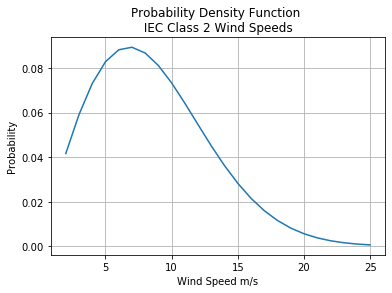

In [12]:
pp = Analysis.Power_Production()
pp.turbine_class = 2
Vrange = np.arange(2,26) # Range of wind speeds being considered
weib_prob = pp.prob_WindDist(Vrange,disttype='pdf')
plt.close('all')
plt.plot(Vrange, weib_prob)
plt.grid(True)
plt.xlabel("Wind Speed m/s")
plt.ylabel('Probability')
plt.title('Probability Density Function \n IEC Class 2 Wind Speeds ')
plt.show()


To get the AEP, we need to provide the wind speeds that the simulations were run for, and the corresponding average power results. Internally, in power_production.AEP, the mean power for a given average wind sped is multiplied times the wind speed's probability, then extrapolated to represent yearly production. 

Note: this might throw a python warning due to some poor pandas indexing practices - to be cleaned up eventually!

To get the AEP for each, the process is simple:

In [13]:
windspeeds_DLC11, seed, IECtype, cmw = Processing.get_windspeeds(cm_DLC11[0], return_df=True)
AEP = pp.AEP(stats_DLC11, windspeeds_DLC11)
print('AEP = {}'.format(AEP))

AEP = [23315075.6884821]


/Users/pbortolo/work/2_openfast/pCrunch/pCrunch/Analysis.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwr_array['windspeeds'] = ws


##### About the wind speed warning:
Here, we get a warning about the input windspeed array. This is because we passed the complete array output from Processing.get_windspeeds to the AEP function. The input windspeeds to power_production.AEP must satisfy either of the following two conditions:
- each wind speed value corresponds to each each statistic value, so `len(windspeeds) = len(stats_df)`
- each wind speed value corresponds to each run in the case matrix, so `len(windspeeds) = len(cm)`

If the second of these conditions is satisfied, it is assumed that each dataset has the same wind speeds corresponding to each run. So, in this case, the wind speeds corresponding to DLC_1.1 and DLC_1.3 should be the same. 

## Plotting
Finally, we can make some plots. There are a few tools we have at our disposal here. First, we can look at more plots that show our design performance as a function of wind speed. Notably, we can pass the stats dictionary or dataframe to these statistics-related scripts.

Currently, `an_plts.stat_curve()` can plot a "statistics curve" for of two types, a bar or a line graph. 

A bar graph is useful to compare design cases easily:

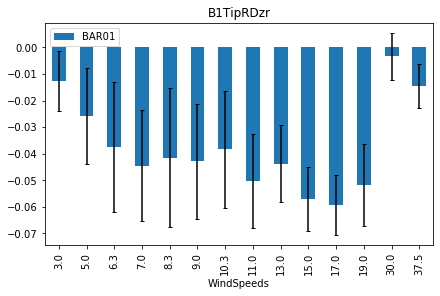

In [19]:
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeed, stats, 'B1TipRDzr', 'bar', names=['BAR01'])
plt.show()

A line graph can be useful to show turbulent wind curves. Here we show the means with a first level of errorbars corresponding to standard deviations, and a second level showing minimums and maximums.

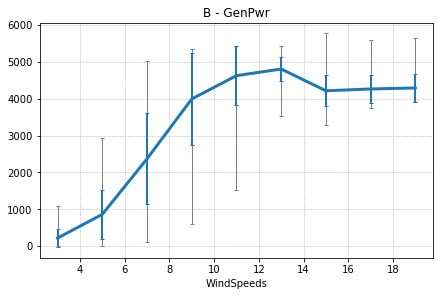

In [15]:
an_plts.stat_curve(windspeeds_DLC11, stats_DLC11, 'GenPwr', 'line', stat_idx=0, names=case_names[0])
plt.show()

### Load Ranking (soon)
We can plot the load rankings... 
... pulling this into `Analysis.py` is in progress.

First, we define how we will classify our comparisons. Most commonly this would be `('IEC','DLC')`, but I'm comparing controllers here. The `classifier_type` functionally refers to the channel of the case matrix to separate the data by, and the `classifier_names` are simply labels for the classifiers. 

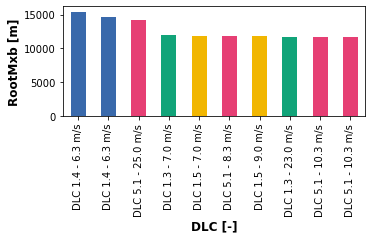

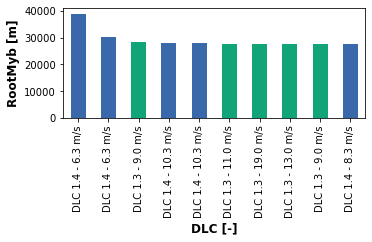

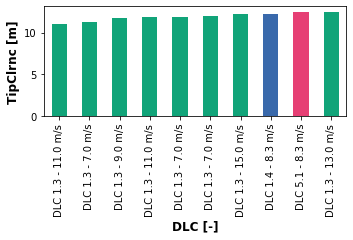

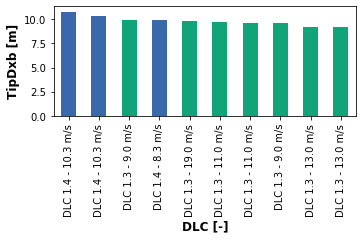

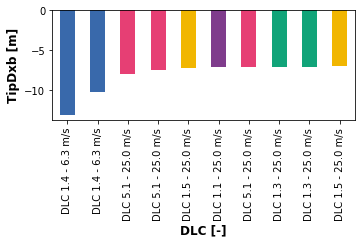

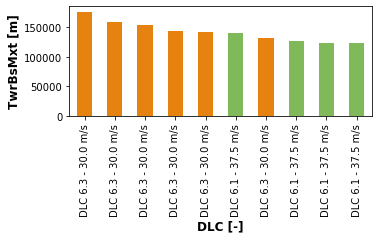

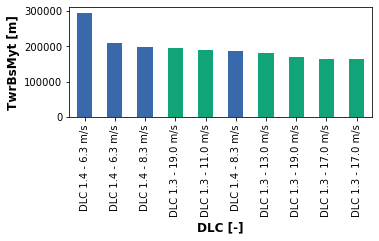

In [16]:
# Plot bar charts
flag_DLC_name = True
n_ranking     = 10
extension     = '.pdf'
from palettable.cartocolors.qualitative import Bold_7

Clr = Bold_7

for k in range(int(0.5 * len(load_ranking_df.columns))):
    ch_i = int(k*2)
    colors = np.zeros((n_ranking, 3))
    case   = load_ranking_df.columns[ch_i][0]
    channel= load_ranking_df.columns[ch_i][1]
    stat   = load_ranking_df.columns[ch_i][2]
    labels = n_ranking * ['']
    for i in range(n_ranking):
        DLC_class = str(cm[0][('IEC', 'DLC')][load_ranking_df[case][channel][stat + '_case_idx'][i]])
        if DLC_class == '1.1':
            colors[i,:] = np.array(Clr.colors[0])/256.
        elif DLC_class == '1.3':
            colors[i,:] = np.array(Clr.colors[1])/256.
        elif DLC_class == '1.4':
            colors[i,:] = np.array(Clr.colors[2])/256.
        elif DLC_class == '1.5':
            colors[i,:] = np.array(Clr.colors[3])/256.
        elif DLC_class == '5.1':
            colors[i,:] = np.array(Clr.colors[4])/256.
        elif DLC_class == '6.1':
            colors[i,:] = np.array(Clr.colors[5])/256.
        elif DLC_class == '6.3':
            colors[i,:] = np.array(Clr.colors[6])/256.
        else:
            colors[i,:] = np.array(Clr.colors[7])/256.

        start = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]].find('_U') + 2
        end   = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]].find('.') + 2
        WS = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]][start:end]

        labels[i] = 'DLC ' + DLC_class +' - ' + WS + ' m/s'
        labels_index = load_ranking_df[case][channel][stat + '_case_idx'][0:n_ranking]


    fig, ax = plt.subplots()
    #ax.set_ylim([-20., 0.])
    #cl = -15.9 # 6.2
    #plt.plot([-2. , 12.],[cl, cl], '--', color = np.array(Clr.colors[2])/256.)
    load_ranking_df[case][channel][stat][0:n_ranking].plot.bar(color=colors)
    #plt.title('BAR01 - Vout 19 m/s', fontsize=10+2, fontweight='bold')
    plt.xlabel('DLC [-]', fontsize=10+2, fontweight='bold')
    plt.ylabel(channel + ' ' + uom[k], fontsize=10+2, fontweight='bold')
    if flag_DLC_name:
        plt.xticks(np.arange(n_ranking), labels=labels)
    else:
        plt.xticks(np.arange(n_ranking), labels=labels_index)
    plt.subplots_adjust(bottom = 0.5, left = 0.2)
    fig.savefig(output_folder + 'ranking_' + case + '_' + channel + '_' + stat + extension)
    
plt.show()

In [17]:
load_ranking_df

B                                                              \
     B1TipRDz                                       B1TipTDx                
          max max_case_idx       min min_case_idx        max max_case_idx   
0    0.298332          109 -0.169040          113  22.209883          112   
1    0.226340          111 -0.162426          112  18.704507          113   
2    0.189485          160 -0.156564           74  18.368633           83   
3    0.136274          108 -0.148611           78  17.804701          123   
4    0.097933           63 -0.144296           87  17.317619           89   
..        ...          ...       ...          ...        ...          ...   
193 -0.024093           41 -0.034831          192   6.282483          144   
194 -0.025655          131 -0.034501          196   6.112990          115   
195 -0.028144           40 -0.033421          116   5.690581          116   
196 -0.032183          136 -0.033421          115   5.502202            1   
197 -0.041839          137 -0.033421          114   5.444718          148   

                                                  ...                        \
                            RootMxb               ... TipClrnc                
           min min_case_idx     abs abs_case_idx  ...      min min_case_idx   
0   -23.616001          109     0.0          197  ...      0.0            0   
1   -20.323821          108     0.0           73  ...      0.0          126   
2   -15.066021          149     0.0           71  ...      0.0          127   
3   -14.626940          146     0.0           70  ...      0.0          128   
4   -14.286237          171     0.0           69  ...      0.0          129   
..         ...          ...     ...          ...  ...      ...          ...   
193   2.913643           14     0.0          129  ...      0.0           69   
194   2.956615           13     0.0          128  ...      0.0           70   
195   3.033209           11     0.0          127  ...      0.0           71   
196   3.331681           16     0.0          126  ...      0.0           73   
197   4.169955           17     0.0            0  ...      0.0          197   

                                                                       \
    TipDxb                                      TwrBsMxt                
       max max_case_idx  min min_case_idx            abs abs_case_idx   
0      0.0          197  0.0            0  167454.724031          190   
1      0.0           73  0.0          126  152758.685650          192   
2      0.0           71  0.0          127  150135.646190          188   
3      0.0           70  0.0          128  142084.470999          175   
4      0.0           69  0.0          129  138732.813153          177   
..     ...          ...  ...          ...            ...          ...   
193    0.0          129  0.0           69    9959.628654            4   
194    0.0          128  0.0           70    8363.045322            5   
195    0.0          127  0.0           71    8035.107191          120   
196    0.0          126  0.0           73    4808.782242          117   
197    0.0            0  0.0          197    3691.482569          116   

                                 
          TwrBsMyt               
               abs abs_case_idx  
0    303713.436087          109  
1    252914.959559           45  
2    242601.286864           92  
3    241935.189613           97  
4    240568.371615           91  
..             ...          ...  
193   67904.138656            5  
194   63685.323045          114  
195   54862.251691          116  
196   52983.495305          117  
197   51236.285721          115  

[198 rows x 22 columns]

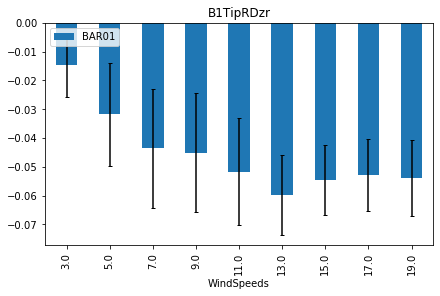

In [26]:
# Plot torsional deformations
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeeds_DLC11, stats_DLC11, 'B1TipRDzr', 'bar', names=['BAR01'])
plt.show()

### Time domain plotting
We can also look at our data from the time domain results. 

We can compare any number of channels using the ROSCO toolbox plotting tools. First we'll load two cases to plot together, then plot the time histories.

In [22]:
#  Load some time domain cases 
filenames = [outfiles[0][12], outfiles[0][13], outfiles[0][14], outfiles[0][15], outfiles[0][16], outfiles[0][17]] # select the 70th run from each dataset
fast_data = fast_io.load_FAST_out(filenames, tmin=0)


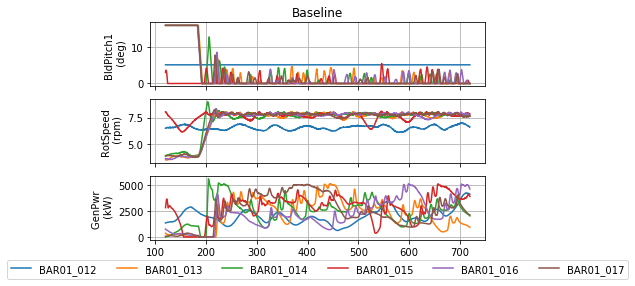

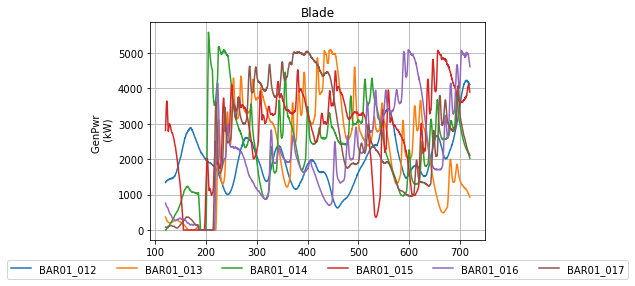

In [23]:
# Define the plots we want to make (can be as many or as few channels and plots as you would like...)
cases = {'Baseline': ['BldPitch1', 'RotSpeed','GenPwr'],
        'Blade' : ['GenPwr']}

# plot
fast_pl.plot_fast_out(cases, fast_data)
plt.show()

### Spectral Analysis

We can additionally do some frequency domain analysis. Here, `spec_cases` is defined by `(channel, run)` where the run index corresponds to the desired plotting index in the loaded fast data.



[WARN] dt from tmax-tmin different from dt from t2-t1
[WARN] dt from tmax-tmin different from dt from t2-t1


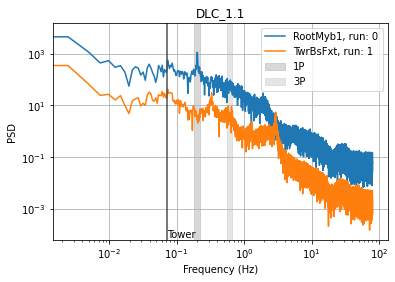

In [19]:
spec_cases = [('RootMyb1', 0), ('TwrBsFxt', 1)]
twrfreq = .0716
twrfreq_label = ['Tower']
fig, ax = fast_pl.plot_spectral(fast_data, spec_cases, 
                                show_RtSpeed=True, RtSpeed_idx=[0],
                                add_freqs=[twrfreq], add_freq_labels=twrfreq_label,
                                averaging='Welch')
ax.set_title('DLC_1.1')
plt.show()

### Other fun plots

Finally, we can plot the data distribution of any channels from our fast output data

In [127]:
channels = ['GenPwr']
caseid = [0,1]
an_plts.distribution(fast_data, channels, caseid, names=['ROSCO', 'Legacy'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## In conclusion...
If you made it this far, thanks for reading... 

There are a number of smaller subfunctionalities that are also available within these tools shows above. Perhaps most importantly, everything is fairly modularar - the hope being that these can provide some high-level tools that everyone can assimilate into their own workflows without too much disruption.

Please add, contribute, fix, etc... That would be great for everyone involved!

In [21]:
fa.ranking_vars = [['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                   ['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                  ['B1TipRDzr','B2TipRDzr','B3TipRDzr']]
fa.ranking_stats= ['max', 'min', 'mean']
uom          = ['[-]', '[-]', '[-]'] * len(cm_DLC11)
load_ranking, load_ranking_df = fa.load_ranking(stats_DLC11, get_df=True)
load_ranking_df.head()

dataset_0                                                            
   B1TipRDz                                                            
        max max_case_idx      mean mean_case_idx       min min_case_idx
0  0.019341           20 -0.014271             0 -0.126048           28
1  0.014081           49 -0.014494             1 -0.123005           20
2  0.013633           48 -0.014704             4 -0.118763           18
3  0.010165            3 -0.016618             3 -0.118316           22
4  0.007952           21 -0.017560             2 -0.114040           14

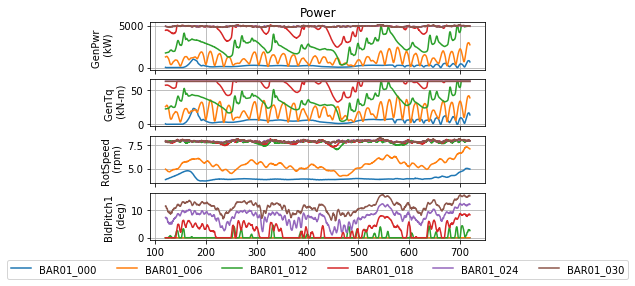

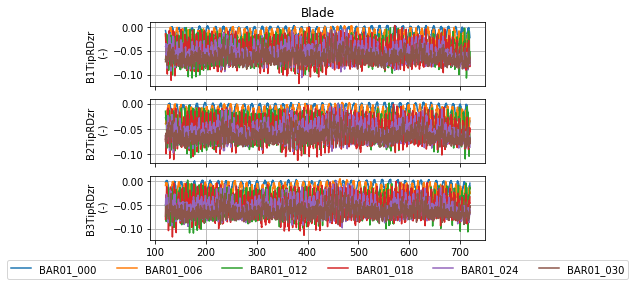

In [22]:
#  Load some time domain cases 
filenames = [outfiles[0][0], outfiles[0][6], outfiles[0][12], outfiles[0][18], outfiles[0][24], outfiles[0][30]]
fast_data = fast_io.load_FAST_out(filenames, tmin=0)
cases = {'Power': ['GenPwr', 'GenTq', 'RotSpeed', 'BldPitch1'],
        'Blade' : ['B1TipRDzr', 'B2TipRDzr', 'B3TipRDzr']}
fast_pl.plot_fast_out(cases, fast_data)
plt.show()